In [48]:
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
sns.set()

#Load in FastTest module, custom module also used in the previous assignment. It is a backtesting framewok written
#in c++ and wrapped with pybind11, source code at https://github.com/ntorm1/Argus
sys.path.append(os.path.abspath('../lib'))
sys.path.append(os.path.abspath('..'))
import FastTest
from FastTest import PortfolioTracerType, ExchangeQueryType,OrderExecutionType
from Hal import Hal


#Question 1.
The momentum crashes paper is an extension of the classic momentum factor quantitative strategy that is used by many quantitative funds, mutual funds, and ETF's. The basics of a momentum strategy is to buy the winners and sell the losers, under the assumpetion that stocks, or any underlying asset, tend to trend in a direction. The paper notes that this type of strategy has been proven to beat buy and hold market strategies but is exposed to tail risk the authors call momentum crashes. 

These periods are in bear markets and the reasoning behind them is explained as the following: When the market falls over the fomration period of the momentum strategy, the momentum portfolio is likely to be long low beta stocks and short high beta stocks. As a result the portfolio beta will be largely negative and when the market rebounds the momentum strategy will crash. Further, the paper notes that in these situations the momentum portfolio is effectively short volaility during these periods.

Additionaly, the Authors show that these momentum crashs are predictable and that dynamically hedging the market beta of the portfolio does not improve the returns of the strategy. Instead, to maximize portfolio returns one should implement a strategy that maximizes the unconditional sharpe ratio of the portfolio by scaling the weights on the long-short strategy such that the volatility of the scaled strategy is proportional to the sharpe ratio of the strategy.  

In [2]:
#Question 2.
df = pd.read_csv("C:/Users/natha/Downloads/momentum.csv")
df["Effective date "] = pd.to_datetime(df["Effective date "])
df.set_index("Effective date ", inplace = True)
df.dropna(inplace = True)
df.columns = ["DJTMNMO","DJTMNMO_TR"]
df.tail()

,DJTMNMO,DJTMNMO_TR
Effective date,,
2020-05-05,1363.20,1443.13
2020-05-06,1372.54,1452.91
2020-05-07,1373.43,1454.12
2020-05-08,1355.27,1435.21
2020-05-11,1374.10,1454.99


In [3]:
#Download etf data and join into the existing data
data = yf.download(
            tickers = ["MOM", "MTUM", "SPY"],
            period = "10y",
            interval = "1d",
            group_by = 'ticker',
        )
data.columns = [' '.join(col).strip() for col in data.columns.values] 
data = data[[col for col in data.columns if "Adj" in col]]

df = pd.merge(df, data, left_index = True, right_index = True)
df

[*********************100%***********************]  3 of 3 completed


,DJTMNMO,DJTMNMO_TR,MTUM Adj Close,MOM Adj Close,SPY Adj Close
2013-05-16,1060.16,1067.30,47.120827,24.606100,137.407242
2013-05-17,1059.54,1066.64,47.023937,23.799999,138.736923
2013-05-20,1051.42,1058.48,46.962284,23.760000,138.728607
2013-05-21,1046.75,1053.82,47.164860,24.286800,138.928085
2013-05-22,1044.15,1051.20,46.909443,24.224600,137.897552
...,...,...,...,...,...
2020-05-05,1363.20,1443.13,115.208427,29.392700,273.382599
2020-05-06,1372.54,1452.91,115.179489,29.174999,271.529388
2020-05-07,1373.43,1454.12,116.008965,29.318501,274.805939
2020-05-08,1355.27,1435.21,117.330322,29.309099,279.352966


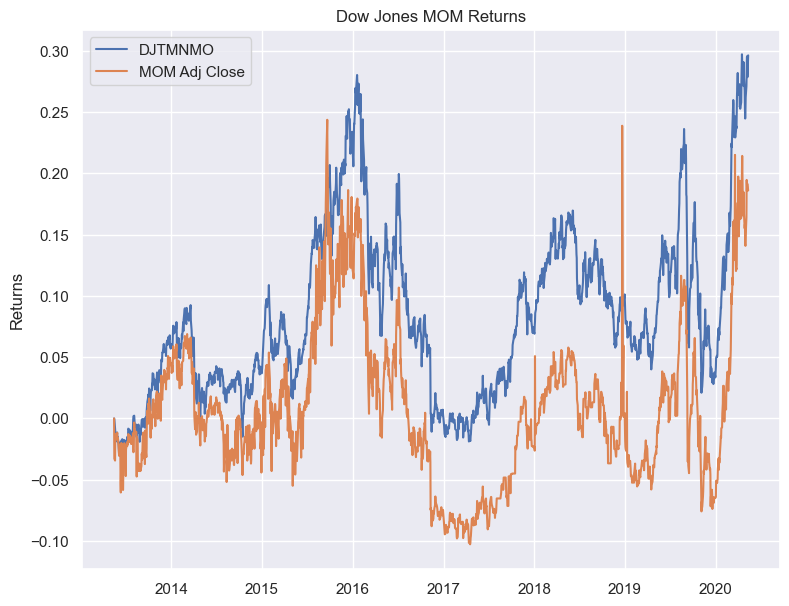

In [4]:
plt.figure(figsize=(9, 7))

for col in ["DJTMNMO", "MOM Adj Close"]:
    close = df[col].values
    returns = (close - close[0]) / close[0]
    plt.plot(df.index, returns, label = col)

plt.ylabel("Returns")
plt.title("Dow Jones MOM Returns")
_ = plt.legend()

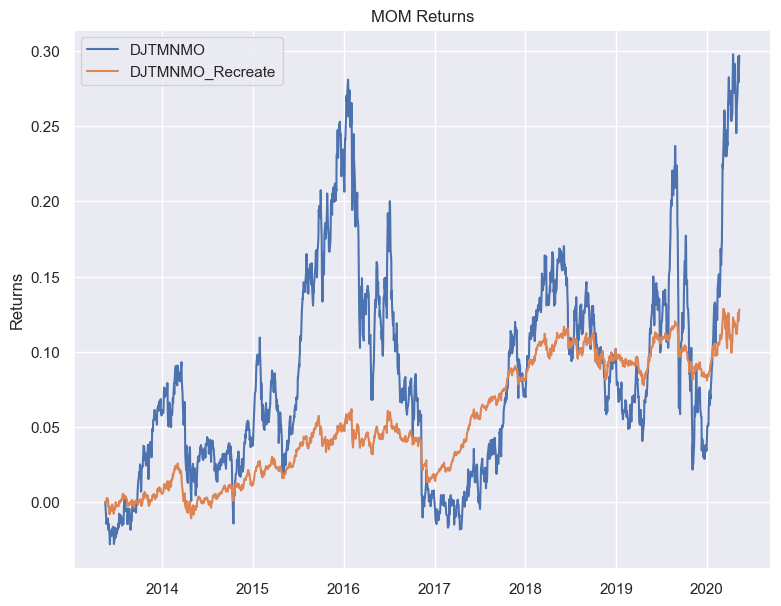

In [5]:
#Question 3
split = .5
daily_returns = df.pct_change()
daily_returns.columns = [col.split(" ")[0] for col in daily_returns.columns]
daily_returns["DJTMNMO_Recreate"] = split * daily_returns["MTUM"] - (1-split) * daily_returns["SPY"]
daily_returns.dropna(inplace = True)

daily_returns = (1+ daily_returns).cumprod()

plt.figure(figsize=(9, 7))

for col in ["DJTMNMO", "DJTMNMO_Recreate"]:
    close = daily_returns[col].values
    returns = (close - close[0]) / close[0]
    plt.plot(daily_returns.index, returns, label = col)

plt.ylabel("Returns")
plt.title("MOM Returns")
_ = plt.legend()

From the above graph we can see that using a portfolio 50% long MTUM and 50% short SPY get's as cumulative that are correlated with DJTMNMO, but have a different maginitude of variance. It is hard to replicate DJTMNMO exactly for two reasons.
1. DJTMNMO goes short the losers of the index, but with the data we are using and the question prompt, we only have MTUM and SPY, so the best we can do is go short the broad market index. This will reduce the variance of the returns of the recreated portfolio as shorting SPY as much lower variance in returns than shorting the indivual losers.
2. DJTMNMO aims to be market netural, i.e. have a beta equal to 0. However with the information we have we can not go beta netural. MTUM does not provide the beta of it's holdings so we cannot appropriately form market neutral portfolio without this information. Instead we go 50% short the market in our recreated portfolio.

The recreation does replicate the DJTMNMO price series to an extent. We see below that shorting SPY greatly increased the corrleation between DJTMNMO and the recreated DJTMNMO portfolio.

In [6]:
daily_returns.corr()

,DJTMNMO,DJTMNMO_TR,MTUM,MOM,SPY,DJTMNMO_Recreate
DJTMNMO,1.000000,0.985225,0.386186,0.862555,0.316669,0.586124
DJTMNMO_TR,0.985225,1.000000,0.530162,0.787728,0.466525,0.700602
MTUM,0.386186,0.530162,1.000000,-0.021351,0.993812,0.942434
MOM,0.862555,0.787728,-0.021351,1.000000,-0.094979,0.194080
SPY,0.316669,0.466525,0.993812,-0.094979,1.000000,0.903668
DJTMNMO_Recreate,0.586124,0.700602,0.942434,0.194080,0.903668,1.000000


In [71]:
#Question 4
#build a new backtest using the daily stock price data of the sp500

data_dir_path = r"C:\Users\natha\OneDrive\Desktop\C++\Argus\Argus\FastTest\tests\SP500_D"

hal = Hal(False, 100000)

exchange_id = "sp500_Daily_Exchange"
broker_id = "sp500_Broker"

broker = hal.new_broker(broker_id,100000.0)
exchange = hal.new_exchange(exchange_id)

file_list = [os.path.join(data_dir_path, f) for f in os.listdir(data_dir_path) if os.path.isfile(os.path.join(data_dir_path, f))]
candles = 0
for _file in file_list:
    _file_base = os.path.basename(_file)
    asset_id = os.path.splitext(_file_base)[0]
    
    df = pd.read_feather(_file)
    df["Date"] = df["Date"] * 1e9
    df.set_index("Date", inplace=True)
    
    #calculate rolling 1 month returns
    df["1_Month_Returns"] = df["Close"].pct_change(20)
    df.dropna(inplace = True)
    
    candles += len(df)
    hal.register_asset_from_df(df, asset_id, exchange_id, broker_id, warmup = 0) 

#Example of one asset loaded, OHLC data, 1 month returns, nanosecond epoch time index
df.tail()

,Adj Close,Close,High,Low,Open,1_Month_Returns
Date,,,,,,
1.679011e+18,164.470001,164.470001,168.389999,163.649994,167.289993,-0.054390
1.679270e+18,165.820007,165.820007,165.949997,163.699997,164.000000,-0.036098
1.679357e+18,166.240005,166.240005,166.990005,165.139999,166.649994,-0.021196
1.679443e+18,161.380005,161.380005,165.940002,161.320007,165.389999,-0.030343
1.679530e+18,164.199997,164.199997,165.430893,162.070007,162.000000,-0.031268


In [72]:
class MomentumStrategy:
    def __init__(self, hal : Hal) -> None:        
        self.exchange = hal.get_exchange(exchange_id)
        self.broker = hal.get_broker(broker_id)
        self.portfolio = hal.get_portfolio("master");
                
    def build(self) -> None:
        return
                
    def on_open(self) -> None:
        return

    def on_close(self) -> None:
        N_stocks = 20
        #Get value of given column for all assets listed on the exchange. In this case we want the 
        #one month returns, sorted, and get the N largest
        exchange_features =  exchange.get_exchange_feature(
            "1_Month_Returns",                          #column to get
            query_type = ExchangeQueryType.NLARGEST,    #query type to use (N largest elements)
            N = N_stocks                                #number of assets to return
        )

        #allocate the portfolio by percentage of net liquidation value
        allocations = {asset_id : 1/N_stocks for asset_id in exchange_features.keys()}

        #use the target allocations dict to pass to the portfolio to generate orders so that the portfolio
        #matches the target allocations. Allow a 1% gap in target units vs actual units held
        self.portfolio.order_target_allocations(
            allocations,
            "momentum_strategy",
            .01,
            order_execution_type = OrderExecutionType.EAGER
        )


In [73]:
strategy = MomentumStrategy(hal)
hal.register_strategy(strategy, "momentum_strategy") 
hal.build()
st = time.time()
hal.reset()
hal.run()
et = time.time()

mp = hal.get_portfolio("master")
nlv = mp.get_tracer(PortfolioTracerType.VALUE).get_nlv_history()
    
print(f"FastTest completed in {et-st:.6f} seconds")
print(f"FastTest Final Portfolio Value: {nlv[-1]:,.4f}")
print(f"HAL: candles per seoncd: {(candles / (et-st)):,.3f}")

FastTest completed in 0.240102 seconds
FastTest Final Portfolio Value: 181,655.6447
HAL: candles per seoncd: 2,563,759.839


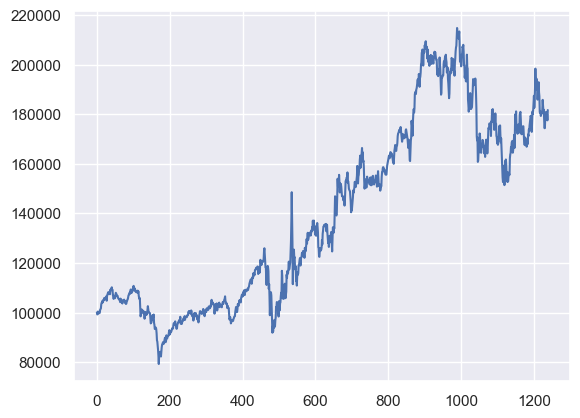

In [74]:
#Lets take a look at how the strategy did

plt.plot(nlv)